<a href="https://colab.research.google.com/github/BraedenKuether/Capstone/blob/MLPrototypes/portedModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyEX
import pyEX as p
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch import optim

     |████████████████████████████████| 143kB 6.4MB/s 
     |████████████████████████████████| 512kB 9.4MB/s 
     |████████████████████████████████| 788kB 10.4MB/s 
     |████████████████████████████████| 358kB 16.8MB/s 
     |████████████████████████████████| 204kB 22.0MB/s 
  Created wheel for sseclient: filename=sseclient-0.0.27-cp36-none-any.whl size=5573 sha256=ed74ff2a8319e6589046c51d99856d0445611f8ee1ad93445e543c5b8a24ea81
  Stored in directory: /root/.cache/pip/wheels/dc/78/2a/e6a65a58ac19de8ebeff9415501a0eec27b2c99792f67e3808
  Created wheel for frozendict: filename=frozendict-1.2-cp36-none-any.whl size=3149 sha256=44692e417d13d578ddd9a69760ccc3c6f0fecbdc844bced09a934de7283f4509
  Stored in directory: /root/.cache/pip/wheels/6c/6c/e9/534386165bd12cf1885582c75eb6d0ffcb321b65c23fe0f834
Successfully built sseclient frozendict
ERROR: jupyter-console 5.2.0 has requirement prompt-toolkit<2.0.0,>=1.0.0, but you'll have prompt-toolkit 3.0.8 which is incompatible.
ERROR: google-colab 

In [ ]:
np.random.seed(123)
class WeightNet(nn.Module):
   def __init__(self,inputShape,numAssets):
        super(WeightNet, self).__init__()
        numFeatures = inputShape[0]-1
        self.lstm = nn.LSTM(numAssets*2,1,3,batch_first=True)
        self.lin = nn.Linear(numFeatures,numAssets)
        self.soft = nn.Softmax(dim=2)

   def forward(self, x):
        x, _ = self.lstm(x)
        #print(x.shape)
        x = x.reshape(64,1,x.shape[1])
        x = self.lin(x)
        #print(x.shape)
        return self.soft(x)

In [ ]:
class PortfolioModel:
  def sharpe(self,d):
    #data = torch.div(self.data,self.data[:,0])
    data = self.data
    #print(d.shape)
    pV = torch.sum(torch.multiply(data,d),axis=2)
    #print(pV[0])
    #print(torch.mean(pR))
    pR = torch.div(torch.sub(pV[:,1:],pV[:,:-1]),pV[:,:-1])
    #print(pR.shape)
    #print(torch.mean(pR)*28)
    #print(torch.sum(pR))
    eR = torch.div(torch.sum(pR),d.shape[0])
    #eR2 = torch.sum(pR*pR)
    #denom = torch.sqrt(eR2 - (eR*eR))
    #sharpe = torch.div(eR,denom)
    sharpe = torch.div(eR,torch.std(pR))
    return -sharpe

  def __init__(self,inputShape,numAssets):
    self.data = None
    print(inputShape,numAssets)
    self.model = WeightNet(inputShape,numAssets)
    self.model = self.model.double()

  def getWeights(self,data):
    cat = []
    for x in data:
      d = pd.DataFrame(x)
      n = np.concatenate([d.values[1:], d.pct_change().values[1:]],axis=1)
      n = n[np.newaxis,:,:]
      cat.append(n)
    features = np.concatenate(cat, axis=0)
    #features = np.concatenate([data.values[1:], data.pct_change().values[1:]], axis=1)
    #print(features.shape)
    #print(data)
    #data = data.iloc[1:]
    #print(data)
    data = data[:,1:]
    self.data = torch.tensor(data)
    #X = features.reshape(1,*features.shape)
    X = features
    X = torch.tensor(X,dtype=torch.double)
    optimizer = optim.Adam(self.model.parameters(), lr=1e-3)
    l = []
    for epochs in range(100):
      optimizer.zero_grad()
      out = self.model(X)
      loss = self.sharpe(out)
      l.append(loss)
      loss.backward()
      optimizer.step()
    plt.plot(l)
    plt.show()
    return self.model(X).detach().numpy()

    


In [ ]:
def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

In [ ]:
def fetchStockData(client, symb):
  '''
  params:
          client: pyEX client object
          symb: string corresponding to stock symbol

  returns:
          tuple of (dayClose,dayReturn) as pyTorch tensors
  '''
  x = client.chartDF(symb,timeframe='5y')
  noWindow = x['close']
  x = rolling_window(x['close'].values,30)
  return (x[:,:,np.newaxis],noWindow)

In [ ]:
IEX_TOKEN = "Tpk_647cd93d6c5842d6978e55c6f79b0e1a"

client = p.Client(api_token = IEX_TOKEN, version='sandbox')

stonks = ['vti', 'agg', 'dbc', 'vixy']
l = []
historical = []
for s in stonks:
 d,nw = fetchStockData(client,s)
 l.append(d)
 historical.append(nw)
 

data = np.concatenate(l,axis=2)
print(data.shape)
hist = pd.concat(historical,axis=1)


(1228, 30, 4)


               close     close     close     close       pdr
date                                                        
2015-12-01       NaN       NaN       NaN       NaN       NaN
2015-12-02  1.000911  0.999503  1.014553  1.073090  1.019017
2015-12-03  0.960579  0.992991  1.003415  1.043344  0.999706
2015-12-04  1.040375  1.004554  0.974813  0.927300  0.987345
2015-12-07  0.987610  0.999093  0.997905  1.008000  0.998222
...              ...       ...       ...       ...       ...
2020-11-20  1.013131  1.017445  0.999276  1.013089  1.010260
2020-11-23  1.022440  1.016569  1.005072  0.983850  1.007751
2020-11-24  1.012729  0.960915  1.014420  1.011162  0.997378
2020-11-25  0.979621  1.018397  1.014215  0.933117  0.992331
2020-11-27  1.033474  1.019970  1.028031  1.034795  1.028054

[1257 rows x 5 columns]
               close     close     close     close       pdr
date                                                        
2015-12-01       NaN       NaN       NaN       NaN       NaN

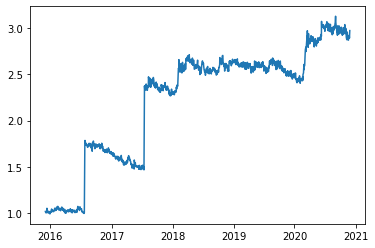

2.2192331569078156

In [ ]:
def eval(data,weights): 
   returnStocks = data.pct_change()
   returnStocks['pdr'] = returnStocks.dot(weights)
   print(1+returnStocks)
   cumDailyReturns = (1+returnStocks).cumprod()
   print(cumDailyReturns)
   plt.plot(cumDailyReturns['pdr'])
   plt.show()
   return cumDailyReturns['pdr'].mean()

eval(hist,[0.2, 0.3, 0.3, 0.2])

In [ ]:
def eval2(data,weights): 
   returnStocks = data.pct_change()
   returnStocks['pdr'] = returnStocks.dot(weights)
   return (1+returnStocks)

(30, 4) 4
(64, 30, 4)


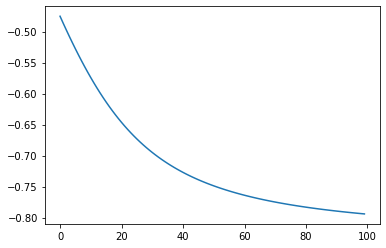

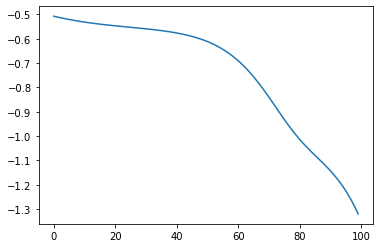

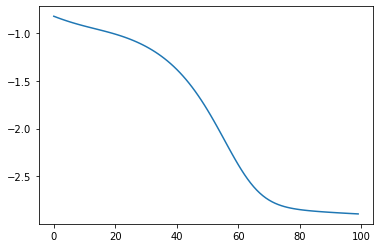

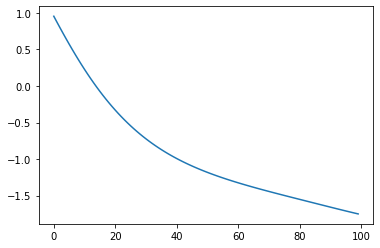

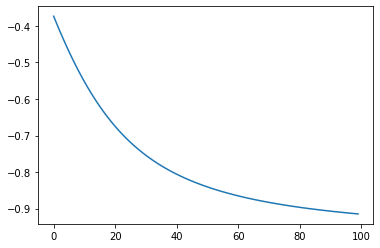

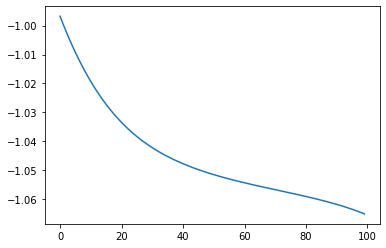

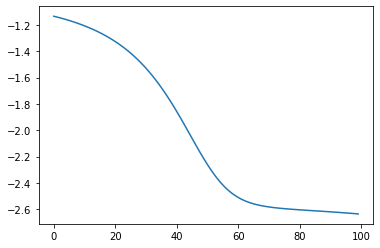

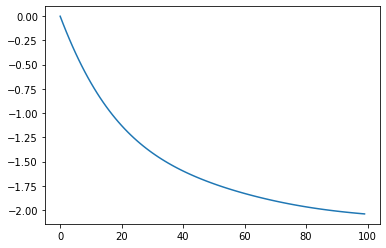

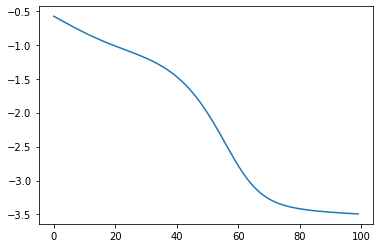

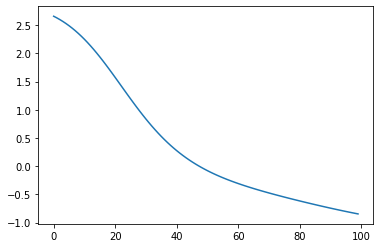

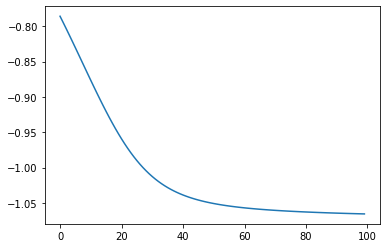

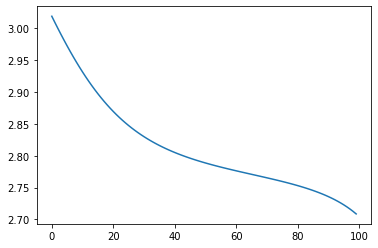

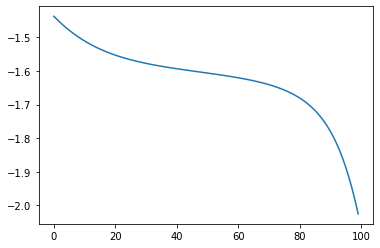

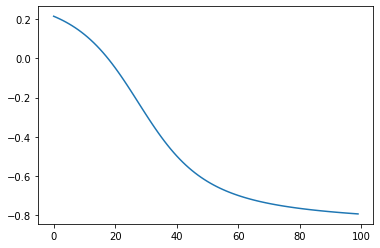

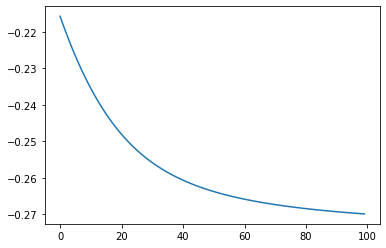

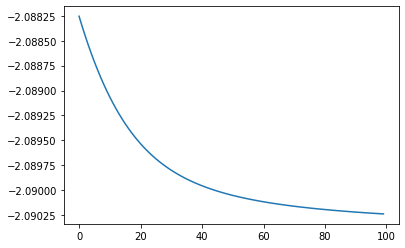

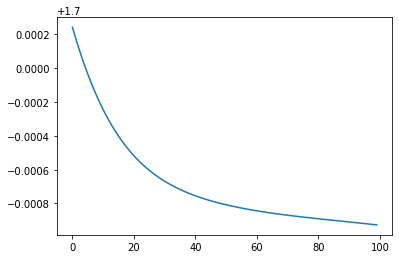

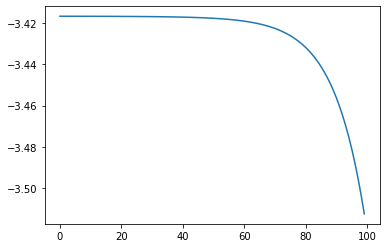

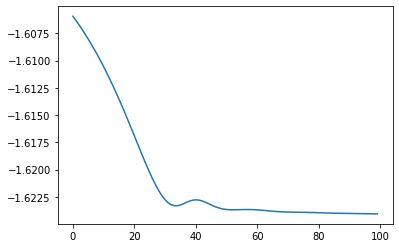

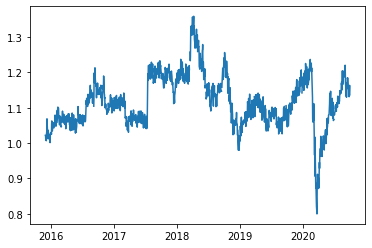

In [ ]:
batches = []
i = 0
while (i+64) < data.shape[0]:
  batches.append(data[i:i+64,:,:])
  #print(data.shape[0])
  i += 64

#print(batches)
cat = []
features = np.empty([1,29,8])
for x in batches[0]:
  d = pd.DataFrame(x)
  n = np.concatenate([d.values[1:], d.pct_change().values[1:]],axis=1)
  n = n[np.newaxis,:,:]
  cat.append(n)

features = np.concatenate(cat, axis=0)

#BATCH SIZE X DAYS-1 X assets*2
# 1.08110000e+02  1.10000000e+02  1.47000000e+01  2.50700000e+02
m = PortfolioModel(batches[0].shape[1:],batches[0].shape[2])
weights = [.25,.25,.25,.25]
returns = []
print(batches[0].shape)
prev = 0
for b in batches:
  returns.append(eval2(hist[prev:prev+64],weights))
  weights = torch.mean(torch.tensor(m.getWeights(b)),0)
  weights = weights.reshape(-1,1)
  #print(weights.shape)
  prev += 64


h = pd.concat(returns,axis=0)
h = h.cumprod()
plt.plot(h['pdr'])
plt.show()



In [ ]:
X = data[0]
m = PortfolioModel(X.shape,X.shape[1])
weights = [.25,.25,.25,.25]
prev = 0
returns = []
print(len(data))
for i in range(1,len(data)):
  if prev+30 >= len(hist):
    #for d in range((i-30)+1):
    #  weights = m.getWeights(pd.DataFrame(data[d]))
    break
  if i % 30 == 0: # every 30 days take all of the data up to this point and rebalance
    #print(hist[prev:prev+30],data[(i-30)])
    returns.append(eval2(hist[prev:prev+30],weights))
    weights = m.getWeights(pd.DataFrame(data[i-30]))
    prev = i
    weights = weights.reshape(-1,1)

h = pd.concat(returns,axis=0)
h = h.cumprod()
plt.plot(h['pdr'])
plt.show()


(30, 4) 4
1228


ValueError: ignored